Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2351 - val_loss: 0.1902
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1306 - val_loss: 0.0814
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0702 - val_loss: 0.0453
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0433 - val_loss: 0.0344
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298 - val_loss: 0.0305
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 - val_loss: 0.0305
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - val_loss: 0.0298
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0248 - val_loss: 0.0291
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - val_loss: 0.0290
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231 - val_loss: 0.0286
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - val_loss: 0.0285
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - val_l

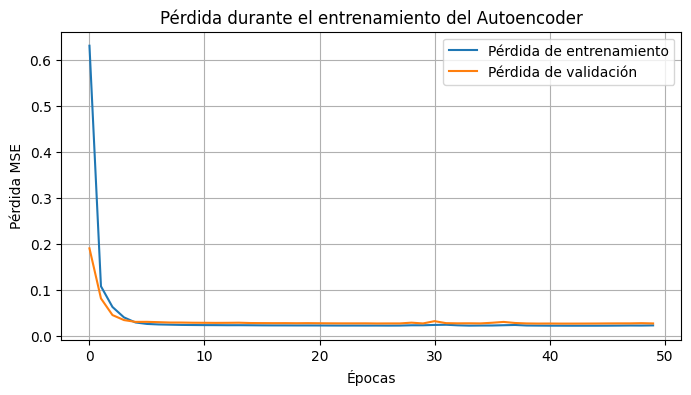

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Alpha real: [0.1, 0.2, 0.3, 0.4]
Alpha predicho: [0.11730846 0.31008688 0.27970406 0.28327563]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Verificar e instalar TensorFlow si no está instalado
try:
    import tensorflow as tf
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install tensorflow
    import tensorflow as tf

# ----- Sistema dinámico -----
Gamma = 5
H = 3
t_span = (0, 11)  # Intervalo de tiempo
t_eval = np.linspace(*t_span, 1000)  # Puntos de evaluación

# Sistema de ecuaciones diferenciales
def sistema_ecuaciones(t, vars, Gamma, H):
    x, y, z, w = vars
    dxdt = Gamma * (x - y - 1.35 * x * y - x * y**2)
    dydt = Gamma * (H * x - 3 * y + 1.35 * x * y + x * y**2 + 4 * (w - y))
    dzdt = Gamma * (z - w - 1.35 * z * w - z * w**2)
    dwdt = Gamma * (H * z - 3 * w + 1.35 * z * w + z * w**2 + 2 * 4 * (y - w))
    return [dxdt, dydt, dzdt, dwdt]

# Generar soluciones para entrenamiento
num_samples = 500
alphas_train = np.random.rand(num_samples, 4)
signals_train = []

for alpha in alphas_train:
    sol = solve_ivp(sistema_ecuaciones, t_span, [0, 0, 0.1, 0], args=(Gamma, H), t_eval=t_eval)
    x, y, z, w = sol.y
    ecg_signal = alpha[0] * x + alpha[1] * y + alpha[2] * z + alpha[3] * w
    signals_train.append(ecg_signal)

signals_train = np.array(signals_train)

# ----- Autoencoder -----
input_dim = signals_train.shape[1]  # Número de puntos en la señal
encoding_dim = 16  # Dimensión comprimida

# Capa de entrada
input_signal = tf.keras.Input(shape=(input_dim,))

# Codificador
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_signal)

# Decodificador
decoded = tf.keras.layers.Dense(4, activation='linear')(encoded)

# Modelo autoencoder
autoencoder = tf.keras.Model(input_signal, decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = autoencoder.fit(signals_train, alphas_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento del Autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Pérdida MSE')
plt.legend()
plt.grid()
plt.show()

# ----- Probar con una nueva señal -----
alpha_test = [0.1, 0.2, 0.3, 0.4]
sol = solve_ivp(sistema_ecuaciones, t_span, [0, 0, 0.1, 0], args=(Gamma, H), t_eval=t_eval)
x, y, z, w = sol.y
ecg_test = alpha_test[0] * x + alpha_test[1] * y + alpha_test[2] * z + alpha_test[3] * w

# Predecir alphas usando el autoencoder
predicted_alpha = autoencoder.predict(ecg_test.reshape(1, -1))[0]

print("Alpha real:", alpha_test)
print("Alpha predicho:", predicted_alpha)
